# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Timothy van den Heuvel"
STUDENT_1_STUDENT_NUMBER = "5606403"
STUDENT_1_NETID = "timvandenheuve"
STUDENT_1_EMAIL = "t.j.vandenheuvel-1@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2d.2 - PD-ILC (11p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

This task focuses on tuning the sequence of feedforward actions using PD-ILC to track a trajectory as well as possible. We assume the following scenario: for control purposes, we only have have access to a perturbed set of robot parameters. Specifically, the mass and inertia are increased with respect to the nominal robot model. Therefore, we observe a significant tracking error when using a PD + pure feedforward controller (see Task 2a.3) and simulating the closed-loop system using the nominal robot parameters. The purpose of applying ILC to this problem setting is to iteratively decrease this tracking error by tuning the feed-forward control action. It needs to be stressed that the controller never has access to the nominal dynamical model and thus the perturbed parameters are also used for the linearization of the system.

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import Array, debug, jit, lax, vmap
import jax.numpy as jnp
import os
from pathlib import Path
from typing import Callable, Dict, Tuple
import warnings

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
# define tolerances for grading
RTOL = float(os.environ.get("RTOL", "1e-4"))  # relative tolerance
ATOL = float(os.environ.get("ATOL", "1e-7"))  # absolute tolerance

## Implementation of PD-ILC (6p)

We model the trajectory to be discretized into $N$ time-steps, each of duration $\delta t$. In the following we will conform to the super-vector / lifted system notation as introduced during the lectures: $\theta_j(k) \in \mathbb{R}^2$ for example corresponds to the link angles at the $k$th time-step and at the $j$th ILC iteration. $Y_j \in \mathbb{R}^{2 (N-1)}$ describes the system output sequence in super-vector notation.

But first, we need to implement a small utility function. Namely, `blk_diag` should take a stack of block matrices (i.e. a tensor of shape $(m, n, o)$, where $(n, o)$ is the block matrix) and place them along the diagonal of a matrix. This resulting block-diagonal matrix will then have the shape $(m \: n, m \: o)$.

This exercise is a good opportunity to get familiar with the [`jax.lax.fori_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html) and [`jax.lax.dynamic_update_slice`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.dynamic_update_slice.html), which allow for jittable `for` loops and array _slicing_ respectively. This will make your function run significantly faster compared to naive, purely Pythonic implementation, which will come in handy later for Q-ILC.

In [4]:
@jit
def blk_diag(a: Array) -> Array:
    """
    Create a block diagonal matrix from a tensor of blocks
    Args:
        a: matrices to be block diagonalized of shape (m, n, o)

    Returns:
        b: block diagonal matrix of shape (m * n, m * o)

    """

    def assign_block_diagonal(i, _b):
        """
        Save the ith block into the block-diagonal matrix `_b`
        Args:
            i: Index of block which we save into the block-diagonal matrix.
            _b: Block diagonal matrix. Should still have zeros at the ith block.
        Returns
        """
        # Assign the block saved in ith entry of `a` to the ith block-diagonal of `_b`
        # Hint: use `jax.lax.dynamic_update_slice` to update the entries of `_b`
        # YOUR CODE HERE
        start_row = i * a.shape[1]
        end_row = i*a.shape[2]
        _b = lax.dynamic_update_slice(_b, a[i], (start_row, end_row))
        return _b

    # Implement for loop to assign each block in `a` to the block-diagonal of `b`
    # Hint: use `jax.lax.fori_loop` and pass `assign_block_diagonal` as an argument
    b = jnp.zeros((a.shape[0] * a.shape[1], a.shape[0] * a.shape[2]))
    # YOUR CODE HERE
    b = lax.fori_loop(0, a.shape[0], assign_block_diagonal, b)

    return b

In [5]:
# DO NOT REMOVE OR MODIFY THIS CELL

# define block entry
_a_block = jnp.array(
    [
        [1.0, 2.0, 0.0],
        [-2.0, 1.0, 4.0],
    ]
)

# we repeat `_a_block` along the 0-dimension to get _a, which has shape (4, 2, 3)
_a = jnp.repeat(jnp.expand_dims(_a_block, axis=0), 4, axis=0)

# resulting block-diagonal matrix `_b` should have shape (8, 12)
_b = blk_diag(_a)

print("Block diagonal matrix:\n", _b)

assert _b.shape[0] == _a.shape[0] * _a.shape[1]
assert _b.shape[1] == _a.shape[0] * _a.shape[2]


Block diagonal matrix:
 [[ 1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  1.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2.  1.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  1.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  1.  4.]]


### Computation of the ILC PD gains (2p)

Implement the function `compute_pd_ilc_gains` to compute the ILC proportional and derivative gain matrices `L` and `D` in super-vector notation. At each time-step $k$, the PD-ILC gain matrices should be equal to:
$$l(k+1) = k_{\mathrm{p,ILC}} \, (C_\mathrm{d}(k+1) \: B_\mathrm{d}(k))^{-1}
\qquad d(k+1) = k_{\mathrm{d,ILC}} \, (C_\mathrm{d}(k+1) \: B_\mathrm{d}(k))^{-1}$$
where $k_{\mathrm{p,ILC}} \in \mathbb{R}$, $k_{\mathrm{d,ILC}} \in \mathbb{R}$ are scalar gains and $B_\mathrm{d}(k)$, $C_\mathrm{d}(k+1)$ are part of the discretized, linear state-space representation.

In [6]:
def compute_pd_ilc_gains(
    Bd_ts: Array,
    Cd_ts: Array,
    kp_ilc: float = 0.0,
    kd_ilc: float = 0.0,
) -> Tuple[Array, Array]:
    """
    Perform one iteration of the PD-ILC algorithm

    Args:
        Bd_ts: time series of discrete-time input matrices of shape (N, 4, 2)
        Cd_ts: time series of discrete-time output matrices of shape (N, 2, 4)
        kp_ilc: scalar proportional gain
        kd_ilc: scalar derivative gain
    Returns:
        L: ILC proportional gain of shape (2 * (N - 1), 2 * (N - 1))
        D: ILC derivative gain  of shape (2 * (N - 1), 2 * (N - 1))
    """
    # number of time-steps
    N = Bd_ts.shape[0]

    # Compute the PD-ILC gains L and D
    # These gains are used to optimize `u_ts` after each ILC iteration
    # Hint: make use of the `blk_diag` function and the`Bd_ts`, and `Cd_ts` arrays.
    L = kp_ilc * jnp.zeros((2 * (N - 1), 2 * (N - 1)))
    D = kd_ilc * jnp.zeros_like(L)

    # YOUR CODE HERE
    Cblock = blk_diag(Cd_ts[: -1]) # up to (N-1)
    Bblock = blk_diag(Bd_ts[: -1])
    L = kp_ilc * jnp.linalg.inv(Cblock @ Bblock)
    D = kd_ilc * jnp.linalg.inv(Cblock @ Bblock)

    return L, D

In [7]:
# DO NOT REMOVE OR MODIFY THIS CELL

_Bd_ts = jnp.array(
    [
        [
            [4.69474793e-03, 4.84245357e-05],
            [8.99674986e-05, 1.96726866e-03],
            [1.69363125e-03, 2.91026735e-04],
            [-2.01081702e-04, -4.44165913e-06],
        ],
        [
            [4.58032646e-03, -1.15100224e-04],
            [-6.28302345e-05, 2.00715823e-03],
            [1.46310101e-03, -4.97562809e-05],
            [-3.49248171e-04, 1.52379565e-05],
        ],
        [
            [2.60964753e-03, -2.87025682e-04],
            [-2.90142700e-04, 2.22991768e-03],
            [-1.97415639e-03, 6.30421758e-04],
            [1.51922983e-04, -7.23507775e-05],
        ],
    ]
)
_Cd_ts = jnp.repeat(
    jnp.array([[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]]), repeats=3, axis=0
)

# PD-ILC gains
_kp_ilc = 1.0
_kd_ilc = 0.2

_L, _D = compute_pd_ilc_gains(_Bd_ts, _Cd_ts, _kp_ilc, _kd_ilc)
print("Computed L:\n", _L)

_L_target = jnp.array(
    [
        [213.1045047, -5.24559096, 0.0, 0.0],
        [-9.74573508, 508.55887234, 0.0, 0.0],
        [0.0, 0.0, 218.4969239, 12.52967729],
        [0.0, 0.0, 6.83962668, 498.60904329],
    ]
)
print("Target L:\n", _L_target)
if not jnp.allclose(_L, _L_target, rtol=RTOL, atol=ATOL):
    warnings.warn("The ILC proportional gain is not correct!")


print("Computed D:\n", _D)
_D_target = jnp.array(
    [
        [42.62090094, -1.04911819, 0.0, 0.0],
        [-1.94914702, 101.71177447, 0.0, 0.0],
        [0.0, 0.0, 43.69938478, 2.50593546],
        [0.0, 0.0, 1.36792534, 99.72180866],
    ]
)
print("Target D:\n", _D_target)
if not jnp.allclose(_D, _D_target, rtol=RTOL, atol=ATOL):
    warnings.warn("The ILC derivative gain is not correct!")


Computed L:
 [[213.10450478  -5.24559096   0.           0.        ]
 [ -9.7457351  508.55887304   0.           0.        ]
 [  0.           0.         218.49692403  12.52967729]
 [  0.           0.           6.83962668 498.60904218]]
Target L:
 [[213.1045047   -5.24559096   0.           0.        ]
 [ -9.74573508 508.55887234   0.           0.        ]
 [  0.           0.         218.4969239   12.52967729]
 [  0.           0.           6.83962668 498.60904329]]
Computed D:
 [[ 42.62090096  -1.04911819   0.           0.        ]
 [ -1.94914702 101.71177461   0.           0.        ]
 [  0.           0.          43.69938481   2.50593546]
 [  0.           0.           1.36792534  99.72180844]]
Target D:
 [[ 42.62090094  -1.04911819   0.           0.        ]
 [ -1.94914702 101.71177447   0.           0.        ]
 [  0.           0.          43.69938478   2.50593546]
 [  0.           0.           1.36792534  99.72180866]]


### Implementation of the learning rule (3p)

Now, please implement the learning rule for PD-ILC

\begin{equation}
    u_{j+1}(k-1) = u_j(k-1) + l(k) \: e_j(k) + d(k) \: [e_j(k) - e_j(k-1)]
\end{equation}

where $u \in \mathbb{R}^2$ is the ILC action and $e_j(k) = y^\mathrm{d}(k) - y_j(k) \in \mathbb{R}^2$ is the error between the desired output and the actual system output.
The same written in super-vector notation looks like

\begin{equation}
    U_{j+1} = U_{j} + L \: E + D \: \delta E
\end{equation}

where now $U, E, \delta E \in \mathbb{R}^{2 (N-1)}$ and $L, D \in \mathbb{R}^{2 (N-1) \times 2 (N-1)}$.

In [8]:
@jit
def learning_rule_pd_ilc(
    u_ts: Array,
    y_ts: Array,
    y_des_ts: Array,
    L: Array,
    D: Array,
) -> jnp.array:
    """
    Implements the PD-ILC learning rule to compute the ILC control action `U_next` for the next iteration

    Args:
        u_ts: array of shape (N, 2) containing the ILC actions at the current iteration
        y_ts: array of shape (N, 2) containing the system outputs at the current iteration
        y_des_ts: array of shape (N, 2) containing the desired system outputs
        L: proportional ILC gain of shape (2 * (N - 1), 2 * (N - 1))
        D: derivative ILC gain  of shape (2 * (N - 1), 2 * (N - 1))

    Returns:
        u_nextit_ts: array of shape (N, 2) containing the ILC actions at the next iteration
    """
    # number of time-steps
    N = u_ts.shape[0]

    # extract the last (N-1) time-steps of the outputs and transform to super-vector notation
    Y = jnp.zeros((2 * (N - 1)))
    Y_des = jnp.zeros_like(Y)
    # YOUR CODE HERE
    length = 2 * (N - 1)
    Y = y_ts[1:].reshape((length, 1)) # supervector everything but first
    Y_des = y_des_ts[1:].reshape((length, 1))
    # compute the output error E of the last (N-1) time-steps in super-vector notation
    E = jnp.zeros_like(Y)
    # YOUR CODE HERE
    E = Y_des - Y

    # compute the change in error between time-steps in super-vector notation.
    # the change in error should be computed considering **all* time-steps,
    # resulting in an array `delta_E` of shape (2 * (N-1), )
    delta_E = jnp.zeros_like(E)
    # YOUR CODE HERE
    y_length = y_ts[: -1] # all except last
    Y_N = y_length.reshape((length, 1))
    Y_des_N = y_des_ts[: -1].reshape((length, 1))
    delta_E = E - (Y_des_N - Y_N)

    # extract the first (N-1) time-steps of the ILC actions and transform to super-vector notation
    U = jnp.zeros((2 * (N - 1)))
    # YOUR CODE HERE
    U = (u_ts[: -1]).reshape((length, 1))

    # implement the PD learning rule and compute the ILC action at the next iteration `U_nextit`
    # should be array of shape (2 * (N-1), ) in super-vector notation
    U_nexit = jnp.zeros_like(U)
    # YOUR CODE HERE
    U_nexit = U + L @ E + D @ delta_E
    # transform `U_nexit` from super-vector notation to array `u_nexit_ts` of shape (N, 2)
    # Hint: the control action at the last time-step is always zero
    # as it does not have an influence on the system states within the given time horizon
    u_nextit_ts = jnp.zeros_like(u_ts)
    # YOUR CODE HERE
    U_nexit_reshaped = U_nexit.reshape((N-1, 2))
    u_nextit_ts = u_nextit_ts.at[: N-1].set(U_nexit_reshaped)

    return u_nextit_ts

In [9]:
# DO NOT REMOVE OR MODIFY THIS CELL
_y_ts = jnp.arange(10, dtype=jnp.double).reshape((-1, 2))
_y_des_ts = jnp.arange(start=10, step=-1, stop=0, dtype=jnp.double).reshape((-1, 2))
_u_ts = jnp.arange(0, 10, dtype=jnp.double).reshape((5, 2))
_N = _y_ts.shape[0]  # number of time-steps
_L = jnp.eye(2 * (_N - 1))
_D = 0.1 * jnp.eye(2 * (_N - 1))

_u_nextit_ts = learning_rule_pd_ilc(_u_ts, _y_ts, _y_des_ts, _L, _D)
print("Computed ILC action at the next iteration:\n", _u_nextit_ts)

# target for next ILC actuation sequence
_u_nextit_ts_target = jnp.array(
    [
        [5.6, 4.6],
        [3.6, 2.6],
        [1.6, 0.6],
        [-0.4, -1.4],
        [0.0, 0.0],
    ]
)
print("Target ILC action at the next iteration:\n", _u_nextit_ts_target)
# make sure that the results of your implementation matches the target
assert jnp.allclose(_u_nextit_ts_target, _u_nextit_ts, rtol=RTOL, atol=ATOL)


Computed ILC action at the next iteration:
 [[ 5.6  4.6]
 [ 3.6  2.6]
 [ 1.6  0.6]
 [-0.4 -1.4]
 [ 0.   0. ]]
Target ILC action at the next iteration:
 [[ 5.6  4.6]
 [ 3.6  2.6]
 [ 1.6  0.6]
 [-0.4 -1.4]
 [ 0.   0. ]]


Next, please study the implementation of the functions `init_ilc_its` and `apply_ilc_control_action_to_system` in `ilc.py` to understand the structure of the `ilc_its` dictionary, which stores the system states, inputs and outputs across iterations and simulation time. Afterwards, please implement the `run_pd_ilc` and `pd_ilc_iteration` function below to execute PD-ILC. The main steps are:

1. Linearizing the system about the given trajectory.
2. Call the function `compute_pd_ilc_gains`to compute the PD-ILC gains and store them in the `L` and `D` variables.
3. Computing the feedforward torque sequence $\tau_\mathrm{ilc} \in \mathbb{R}^{N \times 2}$ to be applied to the system.
4. Defining the error $E_j$ between the desired system output sequence $Y^\mathrm{d}_j$ and the actual system output sequence $Y_j$. 
5. Determining the ILC action sequence at the next iteration $U_{j+1}$ by implementing the PD-ILC learning rule. Following the usual convention, please make sure to only update the first $N-1$ entries of the ILC control action. Similarily, the learning rule should only consider the last $N-1$ entries of $E \in \mathbb{R}^{N}$. Within the learning rule, we set the filter $Q$ to the identity matrix 


In [10]:
from ilc import init_ilc_its, apply_ilc_control_action_to_system

# import linearize_closed_loop_fb_system_about_trajectory from linearization.ipynb
from ipynb.fs.full.linearization import linearize_closed_loop_fb_system_about_trajectory


def run_pd_ilc(
    rp: dict,
    traj_ts: Dict[str, Array],
    th_0: Array,
    th_d_0: Array,
    num_iterations: int,
    kp_ilc: float = 0.0,
    kd_ilc: float = 0.0,
    kp_fb: Array = jnp.zeros((2, 2)),
    kd_fb: Array = jnp.zeros((2, 2)),
    rp_perturbed: dict = None,
):
    """
    Run the PD-ILC algorithm to track a desired trajectory
    Args:
        rp: dictionary of robot parameters
        traj_ts: dictionary of time series of trajectories
        th_0: initial link angles of shape (2,)
        th_d_0: initial link angular velocities of shape (2,)
        num_iterations: number of iterations of the Q-ILC algorithm
        kp_ilc: scalar proportional gain
        kd_ilc: scalar derivative gain
        kp_fb: proportional gains of the parallel feedback controller of shape (2, 2)
        kd_fb: derivative gains of the parallel feedback controller of shape (2, 2)
        rp_perturbed: dictionary of perturbed robot parameters used for linearizing the model and computing the
            trajectory equilibrium torque. If not specified, the nominal robot parameters are used.
    Returns:
        ilc_its: dictionary to track states across iterations and time steps
    """
    # number of time-steps
    N = traj_ts["t_ts"].shape[0]

    # define perturbed robot parameters used for linearizing the robot
    if rp_perturbed is None:
        rp_perturbed = rp.copy()

    # linearize the system about the trajectory with the corresponding equilibrium states and torques
    #    - tau_eq_ts is the compute equilbrium torque
    #    - Ad_ts, Bd_ts, Cd_ts, Dd_ts are the resulting discrete-time, time-varying, linear state-space matrices
    # It is not allowed to use `rp` here, as the controller is not allowed to have access to the
    # nominal robot model.
    # Hint: use a function from the `linearization.ipynb` notebook.
    tau_eq_ts = jnp.zeros((N, 2))
    Ad_ts, Bd_ts = jnp.zeros((N, 4, 4)), jnp.zeros((N, 4, 2))
    Cd_ts, Dd_ts = jnp.zeros((N, 2, 4)), jnp.zeros((N, 2, 2))
    # YOUR CODE HERE
    tau_eq_ts, Ad_ts, Bd_ts, Cd_ts, Dd_ts = linearize_closed_loop_fb_system_about_trajectory(rp_perturbed,
                                                                                          traj_ts, kp_fb, kd_fb)

    # we estimate the ILC control action initially to be zero
    # the torque at the last time index is always zero and never applied to the system
    u_ts = jnp.zeros_like(traj_ts["th_ts"])

    # initialize the dictionary to save iterations
    ilc_its = init_ilc_its(num_iterations, traj_ts)
    ilc_its["tau_eq_ts"] = tau_eq_ts
    ilc_its["u_nextit_ts"] = u_ts

    # Compute the PD-ILC gains L and D
    L = jnp.zeros((2 * (N - 1), 2 * (N - 1)))
    D = jnp.zeros_like(L)
    # YOUR CODE HERE
    L,D = compute_pd_ilc_gains(Bd_ts,Cd_ts,kp_ilc,kd_ilc)

    # this is the main loop for iterations
    ilc_its = lax.fori_loop(
        0,  # lower bound
        num_iterations,  # upper bound
        partial(
            pd_ilc_iteration,
            rp,
            traj_ts,
            th_0,
            th_d_0,
            tau_eq_ts,
            L,
            D,
            kp_fb,
            kd_fb,
        ),  # function to be called
        ilc_its,  # init_val
    )

    # remove u_ts_next_it entries only needed for the loop
    ilc_its.pop("u_nextit_ts")

    return ilc_its


@jit
def pd_ilc_iteration(
    rp: dict,
    traj_ts: Dict[str, Array],
    th_0: Array,
    th_d_0: Array,
    tau_eq_ts: Array,
    L: Array,
    D: Array,
    kp_fb: Array,
    kd_fb: Array,
    it: int,
    ilc_its: Dict[str, Array],
) -> Dict[str, Array]:
    """
    Perform one iteration of the PD-ILC algorithm

    Args:
        rp: dictionary of robot parameters
        traj_ts: dictionary of time series of trajectories
        th_0: initial link angles of shape (2,)
        th_d_0: initial link angular velocities of shape (2,)
        tau_eq_ts: time series of equilibrium torques of shape (N, 2)
        L: ILC proportional gain of shape (2 * (N - 1), 2 * (N - 1))
        D: ILC derivative gain  of shape (2 * (N - 1), 2 * (N - 1))
        kp_fb: proportional gains of the parallel feedback controller of shape (2, 2)
        kd_fb: derivative gains of the parallel feedback controller of shape (2, 2)
        it: iteration index
        ilc_its: dictionary to track states across iterations and time steps
    Returns:
        ilc_its: updated dictionary to track states across iterations and time steps
    """
    # Read-out the ILC action `u_ts` computed at the end of the last iteration
    u_ts = ilc_its["u_nextit_ts"]
    ilc_its["u_its"] = ilc_its["u_its"].at[it].set(u_ts)

    # Compute the feedforward torque sequence tau_ilc_ts as a sum of
    # the equilbrium torque and the ILC control action
    tau_ilc_ts = jnp.zeros_like(tau_eq_ts)
    # YOUR CODE HERE
    tau_ilc_ts = u_ts + tau_eq_ts

    # simulate the system with the current control action
    sim_ts, ilc_its = apply_ilc_control_action_to_system(
        rp=rp,
        traj_ts=traj_ts,
        th_0=th_0,
        th_d_0=th_d_0,
        it=it,
        ilc_its=ilc_its,
        tau_ilc_ts=tau_ilc_ts,
        kp_fb=kp_fb,
        kd_fb=kd_fb,
    )

    # Call the PD-ILC learning rule
    # Hint: the sequence of link angles is stored in the `traj_ts` and `sim_ts` dictionaries.
    u_nextit_ts = jnp.zeros_like(u_ts)
    # YOUR CODE HERE
    u_nextit_ts = learning_rule_pd_ilc(u_ts,sim_ts["th_ts"],
                                       traj_ts["th_ts"], 
                                       L,
                                       D)


    # Store the ILC action for the next iteration in the dictionary
    ilc_its["u_nextit_ts"] = u_nextit_ts

    return ilc_its

## Let's run it (5p)

Now, let's actually run PD-ILC. As mentioned before, we will use the perturbed robot parameters to derive the control law(s) and the nominal robot model to simulate the double pendulum. The perturbed model namely assumes larger link masses and inertias.

For the PD feedback controller, we set the gains to $k_\mathrm{p} = \mathrm{diag}(500, 500)$ Nm / rad and $k_\mathrm{d} = \mathrm{diag}(50, 50)$ Nm s / rad. Please note that you are **not** allowed to change these gains. Instead, please tune the PD-ILC gains, which are denoted with `kp_ilc` and `kd_ilc`, and the number of ILC iterations to achieve good tracking performance defined as **the Euclidean norm of the RMSE in operational-space being below 0.06 m.** The points are distributed as follows:

- If your PD-ILC algorithm runs through without any errors, you will receive 1 point for completing the implementation.
- The remaining 4 points are distributed based on the performance of the learned controller. You will receive the full 4 points if the Euclidean norm of the RMSE in operational-space is below 0.06 m. If the RMSE is higher than 1 m, you will not receive any performance points.

In [11]:
from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.utils import normalize_link_angles
from jax_double_pendulum.visualization import animate_robot

from ilc_analysis import (
    plot_configuration_space_ilc_convergence,
    animate_configuration_space_trajectory_following_plot,
    animate_operational_space_trajectory_following_plot,
    animate_actuation_plot,
)

# the pertubation factor determines by how much the masses and inertia of the perturbed robot model
# used for control is increased with respect to the actual / nominal systems (i.e. in our case used for simulation)
perturbation_factor = 3

# robot parameters
rp = ROBOT_PARAMS

# perturbed robot parameters used for linearizing the system
rp_perturbed = rp.copy()
rp_perturbed.update(
    {
        "m1": perturbation_factor * rp["m1"],
        "j1": perturbation_factor * rp["j1"],
        "m2": perturbation_factor * rp["m2"],
        "j2": perturbation_factor * rp["j2"],
    }
)

# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# gains of parallel feedback PD controller
# IMPORTANT: you are not allowed to change the feedback PD gains!!!
kp_fb = 500 * jnp.eye(2)  # [Nm/rad]
kd_fb = 50 * jnp.eye(2)  # [Nm s/rad]

# generate ellipse trajectory
traj_ts = generate_ellipse_trajectory(
    rp=rp,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# specify the initial link angles at the beginning of each simulation
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

In [37]:
# number of ILC iterations
# please tune appropiately
num_ilc_iterations = 150

# ILC-PD controller gains
# please tune appropiately
kp_ilc = 0e0  # [Nm/rad]
kd_ilc = 0e0  # [Nm s/rad]

# YOUR CODE HERE
kp_ilc = 3 * 1e-5 # [Nm/rad]
kd_ilc = 3 * 1e-3 # [Nm s/rad]

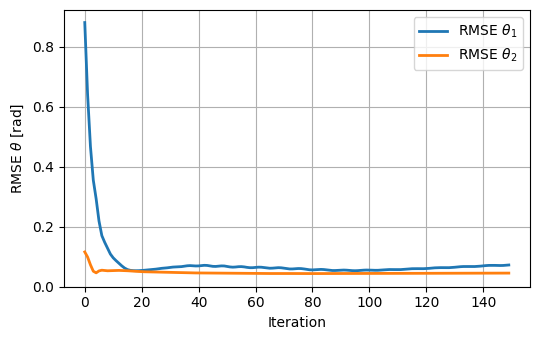

In [38]:
ilc_its = run_pd_ilc(
    rp=rp,
    traj_ts=traj_ts,
    num_iterations=num_ilc_iterations,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    kp_ilc=kp_ilc,
    kd_ilc=kd_ilc,
    kp_fb=kp_fb,
    kd_fb=kd_fb,
    rp_perturbed=rp_perturbed,
)

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# plot configuration-space ILC convergence
plot_configuration_space_ilc_convergence(
    traj_ts,
    ilc_its,
    show=True,
    filepath=str(outputs_dir / "task_2d-2_ilc_convergence.pdf"),
)

In [39]:
# animate the configuration-space evolution through the iterations
if not AUTOGRADING:
    ani_configuration_space = animate_configuration_space_trajectory_following_plot(
        traj_ts,
        ilc_its,
        max_num_animated_its=50,
        show=False,
        filepath=str(
            outputs_dir / "task_2d-2_ilc_configuration_space_trajectory_following.mp4"
        ),
    )
    display(HTML(ani_configuration_space.to_html5_video()))

In [40]:
# animate the operational-space evolution through the iterations
if not AUTOGRADING:
    ani_operational_space = animate_operational_space_trajectory_following_plot(
        traj_ts,
        ilc_its,
        max_num_animated_its=50,
        show=False,
        filepath=str(
            outputs_dir / "task_2d-2_ilc_operational_space_trajectory_following.mp4"
        ),
    )
    display(HTML(ani_operational_space.to_html5_video()))

In [41]:
# animation the actuation sequence through the iterations
if not AUTOGRADING:
    ani_actuation = animate_actuation_plot(
        traj_ts,
        ilc_its,
        max_num_animated_its=50,
        show=False,
        filepath=str(outputs_dir / "task_2d-2_ilc_actuation.mp4"),
    )
    display(HTML(ani_actuation.to_html5_video()))

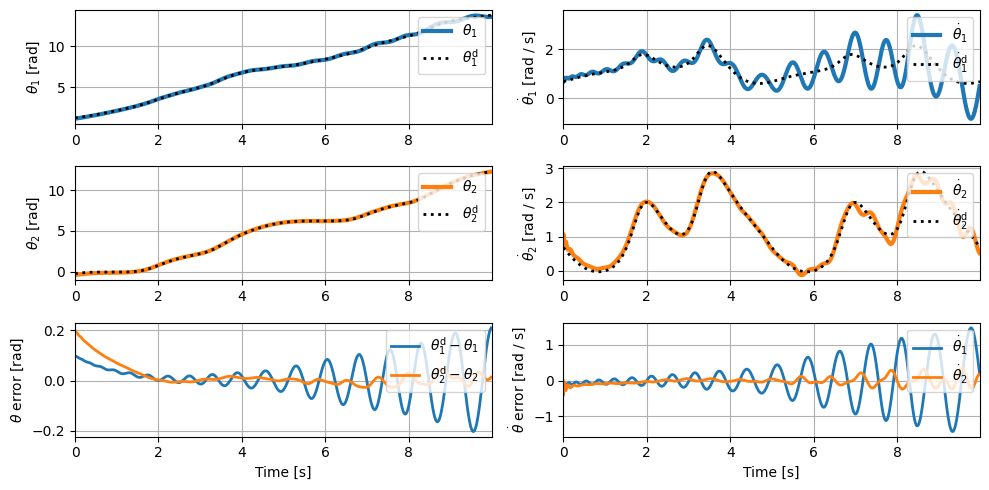

In [42]:
# import feedback controller from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd

# First, extract the feed-forward torques from the last ILC iteration.
# Then, simulate the system again using those torques and a PD feedback controller
# and save the system states to `sim_ts`.
# Hint: the feed-forward torques of shape (num_ilc_its, num_timesteps, 2) are accessible via
# `ilc_its["tau_ilc_its"]` and should be passed to the `tau_ext_ts` argument of the simulation method.
# YOUR CODE HERE
sim_ts =  simulate_robot(
    ROBOT_PARAMS,
    t_ts,
    th_0 = th_0,
    th_d_0 = traj_ts["th_d_ts"][0],
    tau_ext_ts = ilc_its["tau_ilc_its"][-1],
    th_des_ts = traj_ts["th_ts"],
    th_d_des_ts = traj_ts["th_d_ts"],
    th_dd_des_ts = traj_ts["th_dd_ts"],
    ctrl_fb = partial(ctrl_fb_pd, kp=kp_fb, kd=kd_fb),
)

# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(
        outputs_dir / "task_2d-2_configuration_space_trajectory_following.pdf"
    ),
)

In [43]:
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.073 0.045] rad, RMSE theta_d: [0.541 0.109] rad/s, RMSE theta_dd: [4.303 1.984] rad/s^2
RMSE x: 0.1531 m, RMSE x_d: 1.146 m/s, RMSE x_dd: 10.08 m/s^2


In [44]:
# DO NOT REMOVE OR MODIFY THIS CELL

grader_max_impl_points = 1  # points for a correct implementation
grader_max_perf_points = 4  # points for a good prediction performance

rmse_x_norm = jnp.linalg.norm(rmse_x)  # achieved RMSE in operational space
rmse_x_lb = 0.06  # m --> this will result in the full grade
rmse_x_ub = 1.00  # m --> this will result in a zero grade

grader_perf_points = grader_max_perf_points * (
    (1 - (rmse_x_norm - rmse_x_lb) / (rmse_x_ub - rmse_x_lb))
)
grader_perf_points = jnp.clip(grader_perf_points, 0, grader_max_perf_points).item()

grader_points = grader_max_impl_points + grader_perf_points

print(
    f"If you submit the assignment as it is, you will receive {grader_points} points."
)


grader_points

If you submit the assignment as it is, you will receive 4.603936754968764 points.


4.603936754968764

In [20]:
# animate this simulation
if not AUTOGRADING:
    ani_robot = animate_robot(
        rp_perturbed,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2d-2_controlled_robot.mp4"),
    )
    display(HTML(ani_robot.to_html5_video()))